# Learning Position Auctions

In this tutorial, we will extend the ideas from the [previous tutorial](learning-auctions-interdependence.ipynb).  We will consider position auctions, like those found in paid search marketplaces.

## Motivating example

Consider a three-bidder, two-slot position auction where the values for the three bidders are correlated.  There is a signal $c\sim U[0,1]$, which we intepret as a _conversion rate_.  The value of the item for bidder 1 is a random variable $v_1 = x_1 c$ where $x_1 \sim U[0,1]$, similarly for bidder 2 and bidder 3 with independent $x_i \sim U[0,1]$.

The first slot has a click-through-rate (quality) of 1.  The second slot has a click-through-rate of 0.5.  A bidder may purchase one slot only, so we can consider this a special case of a multi-item, unit-demand scenario.

## Architectures and supporting functions

As in the previous tutorial, we will make use of ShadeNet.

### Preliminaries

We will make heavy use of numpy, pandas, and pytorch.

In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')

We will also make use of matplotlib and seaborn for visualization:

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Common components

All mechanism networks will output allocations and payments.  The allocation shape is `[batch_size, bidders+1]`.  The first column represents the probability that the item is not allocated, with all other columns representing the probability that the item is allocated to the respective bidder.  The payment shape is `[batch_size, bidders]`.  Here each column represents the payment of the respective bidder.

We define a generic mechanism as follows:

In [3]:
class MechanismNet(nn.Module):
    def __init__(self, allocation_rule, payment_rule):
        super(MechanismNet, self).__init__()
        self.allocation_rule = allocation_rule
        self.payment_rule = payment_rule
        
    def forward(self, x):
        allocation = self.allocation_rule(x)
        return allocation, allocation*self.payment_rule(x)
    
    
class MechanismWithSignalsNet(nn.Module):
    def __init__(self, allocation_rule, payment_rule):
        super(MechanismWithSignalsNet, self).__init__()
        self.allocation_rule = allocation_rule
        self.payment_rule = payment_rule
        
    def forward(self, x, signals):
        allocation = self.allocation_rule(x, signals)
        return allocation, allocation*self.payment_rule(x, signals)


Utility can thusly be calculated by:

In [4]:
def calc_utility(bids, mechanism, valuation=None, output_components=False):
    valuation = valuation if valuation is not None else bids
    allocation, payment = mechanism(bids)
    if output_components:
        return allocation*valuation-payment, allocation, payment
    else:
        return allocation*valuation-payment
    
def calc_utility_with_signals(bids, signals, mechanism, valuation=None, output_components=False):
    valuation = valuation if valuation is not None else bids
    allocation, payment = mechanism(bids, signals)
    if output_components:
        return allocation*valuation-payment, allocation, payment
    else:
        return allocation*valuation-payment

The `calc_utility` function will return a tensor of shape `[batch_size,bidders]`.

In order to determine if a mechanism is (approximately) DISC, we calculate regret:

In [5]:
# Code inspired by https://github.com/saisrivatsan/deep-opt-auctions/blob/master/regretNet/trainer/trainer.py

def calc_regret(values, mechanism, misreport_samples=100, region_size=1):
    # Extract the basic shapes
    batch_size, bidders = values.shape
    
    # We will generate tensors of the following size
    intermediate_shape = [bidders, misreport_samples, batch_size, bidders]
    
    # Generate multipliers in the range [-1,1)
    unit_multipliers = 2.0*torch.rand(intermediate_shape[1:])-1.0
    # Enforce that all multipliers are in [max {0, 1-region_size}, 1+region_size]
    misreport_multipliers = F.relu(1.0+unit_multipliers*region_size)
    
    # Use the unilateral_mask to only allow unilateral changes to valuations
    unilateral_mask = torch.zeros(intermediate_shape)
    unilateral_mask[np.arange(bidders), :, :, np.arange(bidders)] = 1.0
    
    # Repeat to get a tensor of shape [bidders, misreport_samples, batch_size, bidders]
    misreport_multipliers = misreport_multipliers.unsqueeze(0).repeat([bidders, 1, 1, 1])
    
    # Send to device, if necessary
    if device:
        unilateral_mask = unilateral_mask.to(device)
        misreport_multipliers = misreport_multipliers.to(device)
    
    # Extend the values to be of shape [bidders, misreport_samples, batch_size, bidders] 
    values_reshaped = values.repeat([bidders * misreport_samples, 1]).reshape(intermediate_shape)
    
    # Take the original values and generate 
    # a misreported value using the multipliers.
    misreported_values = values_reshaped * misreport_multipliers
    
    # Enforce unilateral misreports using the bidder_bask
    unilaterally_misreported_values = values_reshaped*(1.0-unilateral_mask)+misreported_values*unilateral_mask
    
    # Intermediate shape is [batch_size * misreport_samples * bidders, bidders]
    # The utility calculation expects data in the shape of [-1, bidders]
    exploded_misreported = unilaterally_misreported_values.reshape([-1, bidders])
    exploded_values = values_reshaped.reshape([-1, bidders])
    
    # Calculate utilities
    utility_true = calc_utility(exploded_values, mechanism)
    utility_misreported = calc_utility(exploded_misreported, mechanism, exploded_values)
    
    # Misreport gain computation
    excess_from_utility = F.relu(utility_misreported - utility_true).reshape(intermediate_shape)*unilateral_mask
                                 
    # First, calculate the maximum gain from deviation for each bidder.  This is along dim=1.
    # Now the shape is [bidders, batch_size, bidders].
    # Again, calculate the maximum gain for each bidder.  This is along new dim=2.
    # Now the shape is [bidders, batch_size].
    # Take the mean across batches.
    # The final size should be [bidders].
    # Each entry represents the expected regret, per bidder, given the batch sample.
    return excess_from_utility.max(dim=1)[0].max(dim=2)[0].mean(dim=1)


def calc_regret_with_signals(values, signals, mechanism, misreport_samples=100, region_size=1):
    # Extract the basic shapes
    batch_size, bidders = values.shape
    batch_size_signals, signal_count = signals.shape
    assert batch_size == batch_size_signals
    
    # We will generate tensors of the following size
    intermediate_shape = [bidders, misreport_samples, batch_size, bidders]
    
    # Generate multipliers in the range [-1,1)
    unit_multipliers = 2.0*torch.rand(intermediate_shape[1:])-1.0
    # Enforce that all multipliers are in [max {0, 1-region_size}, 1+region_size]
    misreport_multipliers = F.relu(1.0+unit_multipliers*region_size)
    
    # Use the unilateral_mask to only allow unilateral changes to valuations
    unilateral_mask = torch.zeros(intermediate_shape)
    unilateral_mask[np.arange(bidders), :, :, np.arange(bidders)] = 1.0
    
    # Repeat to get a tensor of shape [bidders, misreport_samples, batch_size, bidders]
    misreport_multipliers = misreport_multipliers.unsqueeze(0).repeat([bidders, 1, 1, 1])
    
    # Send to device, if necessary
    if device:
        unilateral_mask = unilateral_mask.to(device)
        misreport_multipliers = misreport_multipliers.to(device)
    
    # Extend the values to be of shape [bidders, misreport_samples, batch_size, bidders] 
    values_reshaped = values.repeat([bidders * misreport_samples, 1]).reshape(intermediate_shape)
    
    
    # Take the original values and generate 
    # a misreported value using the multipliers.
    misreported_values = values_reshaped * misreport_multipliers
    
    # Enforce unilateral misreports using the bidder_bask
    unilaterally_misreported_values = values_reshaped*(1.0-unilateral_mask)+misreported_values*unilateral_mask
    
    # Intermediate shape is [batch_size * misreport_samples * bidders, bidders]
    # The utility calculation expects data in the shape of [-1, bidders]
    exploded_misreported = unilaterally_misreported_values.reshape([-1, bidders])
    exploded_values = values_reshaped.reshape([-1, bidders])
    exploded_signals = signals.repeat([bidders * misreport_samples, 1])
    
    # Calculate utilities
    utility_true = calc_utility_with_signals(exploded_values, exploded_signals, mechanism)
    utility_misreported = calc_utility_with_signals(exploded_misreported, exploded_signals, mechanism, exploded_values)
    
    # Misreport gain computation
    excess_from_utility = F.relu(utility_misreported - utility_true).reshape(intermediate_shape)*unilateral_mask
                                 
    # First, calculate the maximum gain from deviation for each bidder.  This is along dim=1.
    # Now the shape is [bidders, batch_size, bidders].
    # Again, calculate the maximum gain for each bidder.  This is along new dim=2.
    # Now the shape is [bidders, batch_size].
    # Take the mean across batches.
    # The final size should be [bidders].
    # Each entry represents the expected regret, per bidder, given the batch sample.
    return excess_from_utility.max(dim=1)[0].max(dim=2)[0].mean(dim=1)

Finally, we can define the training function.

In [6]:
import torch.optim as optim
import torch.utils.data as data_utils

def train(mechanism, values_loader, epochs=1, misreport_samples=100, region_size=1, rho=1, clipping_norm=None):
    # Initialize augmented lagrangian parameters
    lambda_dsic = torch.zeros(bidders).to(device)
    lambda_ir   = torch.zeros(bidders).to(device)

    # Initalize the optimizer
    mechanism_optimizer = optim.Adam(mechanism.parameters(), lr=1e-3)

    report_data = []

    for epoch in range(epochs):
        for batch_idx,(values_list) in enumerate(values_loader):
            values = values_list[0].to(device)
            
            # calculate the utilities and prices
            utility, allocation, payment = calc_utility(
                values, mechanism, output_components=True)
    
            # compute expected regret 
            dsic_violation = calc_regret(
                values, 
                mechanism,
                misreport_samples=misreport_samples,
                region_size=region_size)
    
            # compute individual rationality violation
            ir_violation = F.relu(-utility).mean(dim=0)
    
            # compute components of the loss function
            revenue = payment.sum(dim=-1).mean()
            total_dsic_violation = dsic_violation.sum()
            total_ir_violation = ir_violation.sum()
    
            # Start the gradient computation
            mechanism.zero_grad()
    
            # define the loss 
            loss = -revenue\
                +(lambda_dsic*dsic_violation).sum()\
                +(lambda_ir*ir_violation).sum()\
                +0.5*rho*(total_dsic_violation.pow(2)+total_ir_violation.pow(2))
    
            # Trigger the autogradient calculation
            loss.backward()
            
            if clipping_norm:
                torch.nn.utils.clip_grad_norm_(mechanism.parameters(), clipping_norm)
        
            # Take a step towards the gradient
            mechanism_optimizer.step()
    
            with torch.no_grad():
                mechanism.eval()
                # Update the augmented lagrangian parameters
                dsic_violation_next = calc_regret(
                    values,
                    mechanism,
                    misreport_samples=misreport_samples,
                    region_size=region_size)
                u_next = calc_utility(values, mechanism)
                ir_violation_next = F.relu(-u_next).mean(dim=0)
                lambda_dsic = lambda_dsic + rho * dsic_violation_next
                lambda_ir = lambda_ir + rho * ir_violation_next
                mechanism.train()
            
            report_data.append({
                'epoch': epoch,
                'batch': batch_idx,
                'revenue':revenue.item(),
                'total_dsic_violation':total_dsic_violation.item(),
                'total_ir_violation':total_ir_violation.item(),
                'loss':loss.item()})
            
    return pd.DataFrame(report_data)

def train_with_signals(mechanism, values_and_signals_loader, epochs=1, misreport_samples=100, region_size=1, rho=1, clipping_norm=None):
    # Initialize augmented lagrangian parameters
    lambda_dsic = torch.zeros(bidders).to(device)
    lambda_ir   = torch.zeros(bidders).to(device)

    # Initalize the optimizer
    mechanism_optimizer = optim.Adam(mechanism.parameters(), lr=1e-3)

    report_data = []

    for epoch in range(epochs):
        for batch_idx,(values_list) in enumerate(values_and_signals_loader):
            values = values_list[0].to(device)
            signals = values_list[1].to(device)
            
            # calculate the utilities and prices
            utility, allocation, payment = calc_utility_with_signals(
                values, signals, mechanism, output_components=True)
    
            # compute expected regret 
            dsic_violation = calc_regret_with_signals(
                values,
                signals,
                mechanism,
                misreport_samples=misreport_samples,
                region_size=region_size)
    
            # compute individual rationality violation
            ir_violation = F.relu(-utility).mean(dim=0)
    
            # compute components of the loss function
            revenue = payment.sum(dim=-1).mean()
            total_dsic_violation = dsic_violation.sum()
            total_ir_violation = ir_violation.sum()
    
            # Start the gradient computation
            mechanism.zero_grad()
    
            # define the loss 
            loss = -revenue\
                +(lambda_dsic*dsic_violation).sum()\
                +(lambda_ir*ir_violation).sum()\
                +0.5*rho*(total_dsic_violation.pow(2)+total_ir_violation.pow(2))
    
            # Trigger the autogradient calculation
            loss.backward()
            
            if clipping_norm:
                torch.nn.utils.clip_grad_norm_(mechanism.parameters(), clipping_norm)
        
            # Take a step towards the gradient
            mechanism_optimizer.step()
    
            with torch.no_grad():
                mechanism.eval()
                # Update the augmented lagrangian parameters
                dsic_violation_next = calc_regret_with_signals(
                    values,
                    signals,
                    mechanism,
                    misreport_samples=misreport_samples,
                    region_size=region_size)
                u_next = calc_utility_with_signals(values, signals, mechanism)
                ir_violation_next = F.relu(-u_next).mean(dim=0)
                lambda_dsic = lambda_dsic + rho * dsic_violation_next
                lambda_ir = lambda_ir + rho * ir_violation_next
                mechanism.train()
            
            report_data.append({
                'epoch': epoch,
                'batch': batch_idx,
                'revenue':revenue.item(),
                'total_dsic_violation':total_dsic_violation.item(),
                'total_ir_violation':total_ir_violation.item(),
                'loss':loss.item()})
            
    return pd.DataFrame(report_data)

Now, we pre-compute the outcomes for each feasible slot configuration using the following number of bidders:

In [7]:
bidders = 3
slots = 2

# Clicks for no-allocation,
# Clicks for first slot
# Clicks for second slot
click_curve = torch.tensor([[0,1, 0.5]]).float().to(device)

def bidders_to_index(allocated_bidders):
    idx = [0] * bidders
    for i,p in enumerate(allocated_bidders):
        idx[p] = i+1
    return idx

all_bidders = set(range(bidders))
curve_indices = [[0] * bidders] # initialize to empty slate

for b1 in all_bidders:
    curve_indices.append(bidders_to_index([b1]))

for b1 in all_bidders:
    for b2 in all_bidders - set([b1]):
        curve_indices.append(bidders_to_index([b1,b2]))

outcomes = click_curve[0,curve_indices]
outcome_count = outcomes.shape[0]

## ShadeNet

ShadeNet is a modification to RegretNet that uses a network to compute the bid _shading_ factor to compute payments.  That is, the payment is equal to the product of the bid a factor in [0,1].

The allocation network is defined as follows:

In [8]:
class ShadeNetAllocation(nn.Module):
    def __init__(self, agents, features, hidden_units, act_fn=F.leaky_relu):
        super(ShadeNetAllocation, self).__init__()
        self.features = features
        self.act_fn = act_fn
        self.initial_layer = nn.Linear(agents, agents * features)
        self.recurrent = nn.LSTM(features, hidden_units, batch_first=True, bidirectional=True)
        self.last_layer = nn.Linear(2 * hidden_units * agents, outcome_count)
        
    def forward(self, x):
        batch_size, agents = x.shape
        x = self.act_fn(self.initial_layer(x)).view(batch_size, agents, self.features)
        output, _ = self.recurrent(x)
        output = output.contiguous().view(batch_size, -1)
        output = F.softmax(self.last_layer(output), dim=1)
        return torch.mm(output,outcomes)
    
class ShadeWithSignalsNetAllocation(nn.Module):
    def __init__(self, agents, signal_count, features, hidden_units, act_fn=F.leaky_relu):
        super(ShadeWithSignalsNetAllocation, self).__init__()
        self.agents = agents
        self.features = features
        self.act_fn = act_fn
        self.initial_layer = nn.Linear(agents+signal_count, agents * features)
        self.recurrent = nn.LSTM(features, hidden_units, batch_first=True, bidirectional=True)
        self.last_layer = nn.Linear(2 * hidden_units * agents, outcome_count)
        
    def forward(self, x, signals):
        x = torch.cat((x,signals), dim=1)
        batch_size, agents_signals = x.shape
        x = self.act_fn(self.initial_layer(x)).view(batch_size, self.agents, self.features)
        output, _ = self.recurrent(x)
        output = output.contiguous().view(batch_size, -1)
        output = F.softmax(self.last_layer(output), dim=1)
        return torch.mm(output,outcomes)

The payment network is defined as follows:

In [9]:
class ShadeNetShader(nn.Module):
    def __init__(self, agents, features, hidden_units, act_fn=F.leaky_relu):
        super(ShadeNetShader, self).__init__()
        self.features = features
        self.act_fn = act_fn
        self.initial_layer = nn.Linear(agents, agents * features)
        self.recurrent = nn.LSTM(features, hidden_units, batch_first=True, bidirectional=True)
        self.last_layer = nn.Linear(2 * hidden_units * agents, agents)
        
    def forward(self, x):
        batch_size, agents = x.shape
        x = self.act_fn(self.initial_layer(x)).view(batch_size, agents, self.features)
        output, _ = self.recurrent(x) 
        output = output.contiguous().view(batch_size, -1)
        return torch.sigmoid(self.last_layer(output))
    
class ShadeNetPayment(nn.Module):
    def __init__(self, shader):
        super(ShadeNetPayment, self).__init__()
        self.shader = shader
        
    def forward(self, x):
        return self.shader(x) * x
    
class ShadeWithSignalsNetShader(nn.Module):
    def __init__(self, agents, signal_count, features, hidden_units, act_fn=F.leaky_relu):
        super(ShadeWithSignalsNetShader, self).__init__()
        self.agents = agents
        self.features = features
        self.act_fn = act_fn
        self.initial_layer = nn.Linear(agents+signal_count, agents * features)
        self.recurrent = nn.LSTM(hidden_units, hidden_units, batch_first=True, bidirectional=True)
        self.last_layer = nn.Linear(2 * hidden_units * agents, agents)

    def forward(self, x, signals):
        x = torch.cat((x,signals), dim=1)
        batch_size, agents_signals = x.shape
        x = self.act_fn(self.initial_layer(x)).view(batch_size, self.agents, self.features)
        output, _ = self.recurrent(x) 
        output = output.contiguous().view(batch_size, -1)
        return torch.sigmoid(self.last_layer(output))
    
class ShadeWithSignalsNetPayment(nn.Module):
    def __init__(self, shader):
        super(ShadeWithSignalsNetPayment, self).__init__()
        self.shader = shader
        
    def forward(self, x, signals):
        return self.shader(x, signals) * x

Finally, we can define the ShadeNet mechanism:

In [10]:
def create_shade_net(bidders, features = 100, hidden_units=100, recurrent_calls=5, act_fn=F.leaky_relu):
    return MechanismNet(
        ShadeNetAllocation(bidders, features, hidden_units, act_fn=act_fn),
        ShadeNetPayment(ShadeNetShader(bidders, features, hidden_units, act_fn=act_fn)))

def create_shade_net_with_signals(bidders, signal_count, features=100, hidden_units=100, act_fn=F.leaky_relu):
    return MechanismWithSignalsNet(
        ShadeWithSignalsNetAllocation(bidders, signal_count, features, hidden_units, act_fn=act_fn),
        ShadeWithSignalsNetPayment(ShadeWithSignalsNetShader(bidders, signal_count, features, hidden_units, act_fn=act_fn)))


## Auction for the motivating example



The networks will train on data that is sampled from the value distribution, which is loaded into a `DataLoader`.

In [11]:
sample_size = 1000
batch_size = 64

indepedent_components = torch.rand(sample_size, bidders)
common_components = torch.rand(sample_size, 1)
values = indepedent_components * common_components

values_loader=data_utils.DataLoader(
    data_utils.TensorDataset(values),
    batch_size=batch_size)

values_and_signals_loader=data_utils.DataLoader(
    data_utils.TensorDataset(values, common_components),
    batch_size=batch_size)

Before training the networks, let's establish a GSP baseline.

In [12]:
gsp_revenue = (click_curve[:,1:3]*torch.sort(values.to(device), dim=1, descending=True)[0][:,1:3]).sum(dim=1).mean().item()

We now create a simple ShadeNet and ShadeWithSignalsNet instances.

In [13]:
shade_net = create_shade_net(bidders).to(device)
shade_net_with_signals = create_shade_net_with_signals(bidders, 1).to(device)

We loop over the data for a number of epochs and record traces of the networks learning.

In [14]:
epochs = 100
shade_net_report = train(shade_net, values_loader, epochs=epochs)
shade_net_with_signals_report = train_with_signals(shade_net_with_signals, values_and_signals_loader, epochs=epochs)

Next, let's review the DSIC violations of the network. In the figure below, we can see that networks have a large initial violation then quickly finds a region with low and decreasing violation.

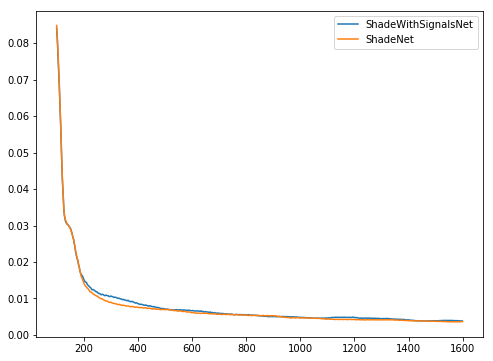

In [15]:
fig, ax = plt.subplots(figsize=(8,6));
ax.plot(shade_net_with_signals_report[['total_dsic_violation']].rolling(100).mean(), label='ShadeWithSignalsNet');
ax.plot(shade_net_report[['total_dsic_violation']].rolling(100).mean(), label='ShadeNet');
ax.legend();

Let's review the revenue of the networks.  Both ShadeNet and ShadeWithSignalsNet improve over GSP revenue with minimal DSIC violation.

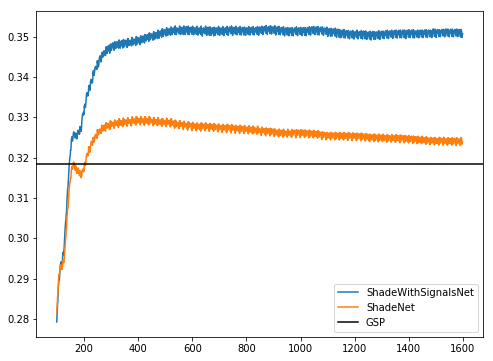

In [16]:
fig, ax = plt.subplots(figsize=(8,6));
ax.plot(shade_net_with_signals_report[['revenue']].rolling(100).mean(), label='ShadeWithSignalsNet');
ax.plot(shade_net_report[['revenue']].rolling(100).mean(), label='ShadeNet');
ax.axhline(gsp_revenue, c='k', label='GSP')
ax.legend();